In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import csv
import cv2
import imageio.v2 as iio
import statistics
from math import sqrt, cos, sin, pi

import sys

racine = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(racine)

from config import chemin_tt_espace

from PIL import Image, ImageDraw, ImageFont
from moviepy.editor import VideoFileClip, CompositeVideoClip, clips_array, ColorClip

from Scripts.generation_grille_table import quadrillage_sur_image
from Scripts.fonctions_positions import coordonnees, ajout_vecteurs_trajectoires, atteintes_lateralite, nuage_frappes, banane_alexis, banane_alexis_cd_r, angles_avant_bras, bdl
from Scripts.fonctions_inertie import heatmap
from Scripts.fonctions_time import time_to_point, frappe
from Scripts.creation_gifs import gif_evol_surf_jA, gif_evol_vit_jA, gif_evol_surf_vit_jA, gif_evol_angle_jA, gif_point

In [ ]:
match="FAN-ZHENDONG_vs_TRULS-MOREGARD"
match='ALEXIS-LEBRUN_vs_MA-LONG'
point="set_1_point_0"

# les dossiers heatmap et evolutions_temporelles ont vocation à stocker des images de façon transitoire. le but est de pour avoir accès aux images qui composent un gif/une vidéo mais on en n'a pas forcément besoin dans le temps donc lorsqu'on a fini d'étudier un point et qu'on passe au suivant, les nouvelles images s'écrivent par dessus.


os.makedirs(os.path.join(chemin_tt_espace,"example",match,point,"output","heatmap"), exist_ok='True')
os.makedirs(os.path.join(chemin_tt_espace,"example",match,point,"output","evolutions_temporelles"), exist_ok='True')
os.makedirs(os.path.join(chemin_tt_espace,"example",match,point,"output","evolutions_temporelles","angle"), exist_ok='True')
os.makedirs(os.path.join(chemin_tt_espace,"example",match,point,"output","evolutions_temporelles","combinaison"), exist_ok='True')
os.makedirs(os.path.join(chemin_tt_espace,"example",match,point,"output","evolutions_temporelles","surface_inertie"), exist_ok='True')
os.makedirs(os.path.join(chemin_tt_espace,"example",match,point,"output","evolutions_temporelles","vitesse"), exist_ok='True')

pos_init_b, vitesse_b, pos_init_jA, vitesse_jA, pos_init_jB, vitesse_jB = coordonnees(match, point, lissage='oui')

nb_pts=len(pos_init_b) # pour tracer les courbes d'évolution au cours du temps
time_points = np.array([f*1/25 for f in range(len(pos_init_b))]) # on a la valeur de la surface atteignable en moins de tlim pour chaque frame et 1 frame dure 1/25s d'où cette discrétisation du temps
xmax=(len(time_points)-1)/25


with open(os.path.join(chemin_tt_espace,"example",match,point,point+"_annotation.csv"), newline='') as fichier :
    set_point_annotation=[]
    reader=csv.reader(fichier)
    for ligne in reader :
        set_point_annotation.append(ligne)

time_frappe=[] # joueur qui frappe, frame de frappe, coordonnées de la balle fichier annotation
for i in range(1, len(set_point_annotation)):
    if set_point_annotation[i][8]=='' :
        time_frappe.append([set_point_annotation[i][0], int(set_point_annotation[i][21]), (float(set_point_annotation[i][18]), -float(set_point_annotation[i][19]))])
    elif set_point_annotation[i][8]!='' :
        frappe_service=[set_point_annotation[i][0], int(set_point_annotation[i][21]), (float(set_point_annotation[i][18]), -float(set_point_annotation[i][19]))]

with open(os.path.join(chemin_tt_espace,"example",match,match+"_game.json"),  newline='') as fichier_game:
    data=json.load(fichier_game)
    game=[[cle,val] for cle,val in data.items()]
joueurA=game[0][1]
joueurB=game[1][1]
lateralite_jA=game[2][1]
lateralite_jB=game[3][1]

h, W = 800, 400

In [5]:

point = "set_1_point_0"
match='ALEXIS-LEBRUN_vs_MA-LONG'
#gif_point(match, point, avec_heatmap='oui', avec_banane='non',num_vitesse=1)
match="FAN-ZHENDONG_vs_TRULS-MOREGARD"
gif_point(match, point, avec_heatmap='oui', avec_banane='non',num_vitesse=1)

In [ ]:
import pandas as pd
def correction_csv(compet, match, set, point, num_vitesse=1): # taille de la zone de chaleur du joueurA + création des zones de chaleur frame par frame de chaque joueur pour un point donné dans un match donné (image stockée dans répertoire 'heatmap' dans le dossier du match dans tt-espace)
# si que_taille_zone=='oui', il n'y a pas de génération des images donc réduction du temps de calcul (passe d'environ 2 min à environ 1 min)
# tlim correspond au temps seuil : si le joueur atteint un point dans l'espace en + de tlim alors on considère que ce point ne va pas être atteint donc il ne sera pas coloré en rouge.
    if not os.path.isdir(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips","set_"+str(set)+"_point_"+str(point),"enveloppe")):
        os.mkdir(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips","set_"+str(set)+"_point_"+str(point),"enveloppe"))
    chemin_csv = os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips","set_"+str(set)+"_point_"+str(point),"set_"+str(set)+"_point_"+str(point)+"_annotation.csv")
    df = pd.read_csv(chemin_csv)
    #print(vitesse_jA)
    liste_valeurs_frappe = []
    liste = os.listdir(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips","set_"+str(set)+"_point_"+str(point),"enveloppe"))
    liste_filtree = [element for element in liste if "frappe" not in element]
    liste_filtree.sort()
    liste_filtree.sort(key=len)
    for f in range(len(liste_filtree)):

        chemin_enregistrement = os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips","set_"+str(set)+"_point_"+str(point),"enveloppe",str(f)+".png")


        im = Image.open(chemin_enregistrement).convert('RGB')
        im_np = np.array(im)
        heatmap = im_np[:, :, 0].copy()
        heatmap_normalized_r = ((heatmap - heatmap.min()) / (heatmap.max() - heatmap.min()) * 255).astype(np.uint8)
        heatmap = im_np[:, :, 1].copy()
        heatmap_normalized_g = ((heatmap - heatmap.min()) / (heatmap.max() - heatmap.min()) * 255).astype(np.uint8)
        heatmap = im_np[:, :, 2].copy()
        heatmap_normalized_b = ((heatmap - heatmap.min()) / (heatmap.max() - heatmap.min()) * 255).astype(np.uint8)
        #im2 = im.copy()
        if f in df['time_frappe'].values:
            row = df.iloc[min(df['time_frappe'].tolist().index(f),len(df['time_frappe'].values)-1)]#[df['time_frappe'] == max(0,.values.index(f))]
            x = row['coor_frappe_x']#.values[0]
            y = row['coor_frappe_y']#.values[0]
            center = (int(x + (324 + 152 / 2)), int(y + (263 + 274 / 2)))
            #liste_valeurs_frappe.append(im2.getpixel(center))
            val = '(' + str(heatmap_normalized_r[center[1], center[0]]) + ',' + str(heatmap_normalized_g[center[1], center[0]]) + ',' + str(heatmap_normalized_b[center[1], center[0]]) + ')'
            liste_valeurs_frappe.append(val)
    #print("Point",set,point)
    #print(len(df),len(liste_valeurs_frappe))
    print(liste_valeurs_frappe)
    print(df)
    df['zone_modele'] = liste_valeurs_frappe
    df.to_csv(chemin_csv.replace(".csv","_zone_frappe_modele_frappe_"+str(num_vitesse)+".csv"), index=False)

correction_csv(compet, match, 4, 62, num_vitesse=1)
deze
liste_clips = os.listdir(os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips"))

for clip in liste_clips:
    try:
        correction_csv(compet, match, clip.split("_")[1], clip.split("_")[3], num_vitesse=1)
    except:
        print("pb",clip)

["set_3_point_55","set_4_point_62"]

['(0,255,230)', '(0,0,0)', '(0,255,153)', '(0,0,0)', '(0,255,212)', '(0,0,0)', '(0,255,237)', '(0,0,0)', '(0,163,255)', '(0,163,255)', '(0,163,255)']
              nom  debut  fin   genre  lateralite  set  systeme  \
0   ALEXIS-LEBRUN      0   11  garcon  coup_droit    4  att/att   
1         MA-LONG     12   23  garcon  coup_droit    4  att/att   
2   ALEXIS-LEBRUN     24   32  garcon      revers    4  att/att   
3         MA-LONG     33   42  garcon      revers    4  att/att   
4   ALEXIS-LEBRUN     43   49  garcon      revers    4  att/att   
5         MA-LONG     50   59  garcon      revers    4  att/att   
6   ALEXIS-LEBRUN     60   66  garcon      revers    4  att/att   
7         MA-LONG     67   77  garcon  coup_droit    4  att/att   
8   ALEXIS-LEBRUN     78   93  garcon  coup_droit    4  att/att   
9         MA-LONG     94  107  garcon  coup_droit    4  att/att   
10  ALEXIS-LEBRUN    108  142  garcon      revers    4  att/att   

                  coup type_service      type

NameError: name 'deze' is not defined

In [16]:
def inverser_bleu_vert(chemin_image):
    """
        Fonction permettant d'inverser le bleu et le vert d'une image
    """
    image = cv2.imread(chemin_image)

    # Vérifier si l'image est chargée
    if image is None:
        raise ValueError("L'image n'a pas pu être chargée. Vérifie le chemin du fichier.")

    # Inverser les canaux Bleu et Vert
    image[:, :, [0, 1]] = image[:, :, [1, 0]]  # Échange B et G
    cv2.imwrite(chemin_image, image)


chemin_clips = os.path.join(USER_PREFERENCE["pipeline"]["LOCAL-PIPELINE-TT"],compet,match,"clips")
liste_clips = os.listdir(chemin_clips)

for clip in liste_clips:
    if "set_2" in clip or "set_4" in clip:
        liste_im = os.listdir(os.path.join(chemin_clips,clip,"enveloppe"))
        for im in liste_im:
            inverser_bleu_vert(os.path.join(chemin_clips,clip,"enveloppe",im))

Heatmap (génération + récup 'surfaces_jA')

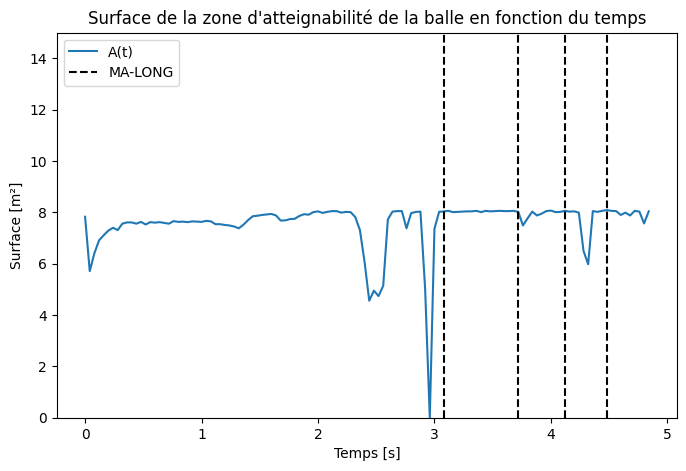

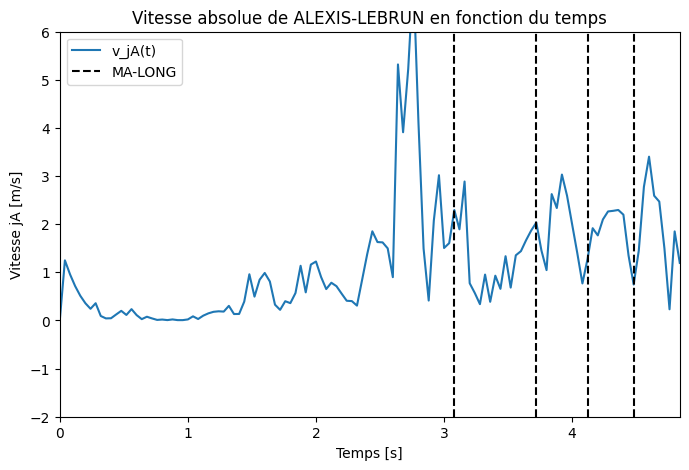

In [3]:
# pour dessiner l'évolution de la surface atteignable en moins de tlim par le joueur en temps réel (comme occupation spatiale Gabin Rolland basket)

c=10 #fonctions_inertie>heatmap
surfaces_jA = heatmap(match, point, 0.8, que_taille_zone='oui')
surface_points = []
for f in range(len(surfaces_jA)):
    surface_points.append(surfaces_jA[f] * c**2 * 10**(-4)) # la liste surfaces_jA contient le nb de carrés de discrétisation de côté c (=10cm) à chaque frame du pt. il suffit donc de multiplier chaque elt de la liste par la surface d'un carré (10^-4 car on transpose en m²)

plt.figure(figsize=(8, 5))
plt.plot(time_points, surface_points, label='A(t)')
plt.xlabel('Temps [s]')
plt.ylabel('Surface [m²]')
plt.title("Surface de la zone d'atteignabilité de la balle en fonction du temps")
plt.ylim(0, 15)

if frappe_service[0]==joueurA :
    plt.axvline(x=frappe_service[1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
elif frappe_service[0]==joueurB :
    plt.axvline(x=frappe_service[1]/25, color='k', linestyle='--', label='{}'.format(joueurB))

for i in range(len(time_frappe)):
    if time_frappe[i][0]==joueurA:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--')
    else:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--')
plt.legend()


# plot de la vitesse du jA en fonction du temps pour pouvoir comparer son évolution à celle de l'aire de la zone

norme_vitesse_jA=[]
for i in range(len(vitesse_jA)):
    vitesse=sqrt(vitesse_jA[i][0]**2 + vitesse_jA[i][1]**2)
    vitesse=vitesse*10**(-2) # pour passer de cm/s à m/s
    norme_vitesse_jA.append(vitesse)

plt.figure(figsize=(8, 5))
plt.plot(time_points, norme_vitesse_jA, label='v_jA(t)')
plt.xlabel('Temps [s]')
plt.ylabel('Vitesse jA [m/s]')
plt.title('Vitesse absolue de {} en fonction du temps'.format(joueurA))
plt.xlim(0, xmax)
plt.ylim(-2, 6)

if frappe_service[0]==joueurA :
    plt.axvline(x=frappe_service[1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
elif frappe_service[0]==joueurB :
    plt.axvline(x=frappe_service[1]/25, color='k', linestyle='--', label='{}'.format(joueurB))

for i in range(len(time_frappe)):
    if time_frappe[i][0]==joueurA:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--')
    else:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--')
plt.legend()

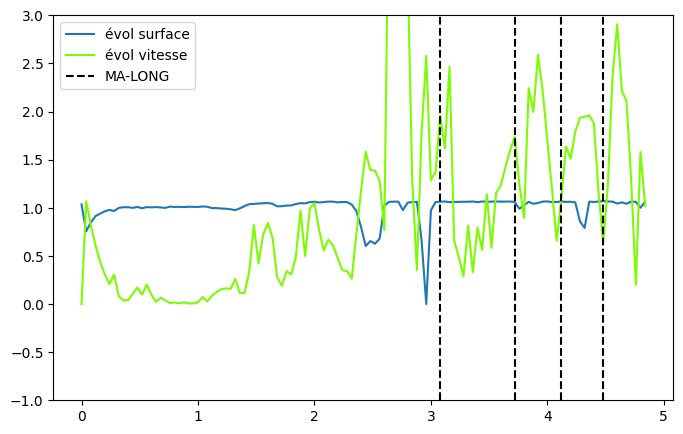

In [4]:
# combinaison des 2 courbes sur un même graphe

norme_vitesse_jA_bis=[]
surface_points_bis=[]
moy_vit=sum(norme_vitesse_jA)/len(norme_vitesse_jA)
moy_surf=sum(surface_points)/len(surface_points)
for i in range(len(norme_vitesse_jA)):
    norme_vitesse_jA_bis.append(norme_vitesse_jA[i]/moy_vit)
    surface_points_bis.append(surface_points[i]/moy_surf)

plt.figure(figsize=(8, 5))
plt.plot(time_points, surface_points_bis, label='évol surface')
plt.plot(time_points, norme_vitesse_jA_bis, color='lawngreen', label='évol vitesse')
if frappe_service[0]==joueurA :
    plt.axvline(x=frappe_service[1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
elif frappe_service[0]==joueurB :
    plt.axvline(x=frappe_service[1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
for i in range(len(time_frappe)):
    if time_frappe[i][0]==joueurA:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--')
    else:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--')
plt.ylim(-1,3)
plt.legend()

In [3]:
# plot angle en fonction du temps

angles_jA = angles_avant_bras(match, point)[0]

plt.figure(figsize=(8, 5))
if lateralite_jA=='gaucher':
    plt.plot(time_points, angles_jA[0], label='angle_jA(t)')
elif lateralite_jA=='droitier':
        plt.plot(time_points, angles_jA[1], label='angle_jA(t)')
plt.xlabel('Temps [s]')
plt.ylabel('Angle jA [rad]')
plt.title('Angle main forte jA')
plt.ylim([-4, 4])

if frappe_service[0]==joueurA :
    plt.axvline(x=frappe_service[1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
elif frappe_service[0]==joueurB :
    plt.axvline(x=frappe_service[1]/25, color='k', linestyle='--', label='{}'.format(joueurB))

for i in range(len(time_frappe)):
    if time_frappe[i][0]==joueurA:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--')
    else:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--')
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/thomas/Documents/GitHub/table-tennis-control-areas\\example\\ALEXIS-LEBRUN_vs_MA-LONG\\set_1_point_0\\csv_json_openpose\\set_1_point_0_angles.csv'

In [ ]:
nuage_frappes(match)

In [ ]:
# combinaison vidéo du pt + gif
video_clip = VideoFileClip('{}/{}/{}/clips/set_{}_point_{}/set_{}_point_{}.mp4'.format(chemin_pipeline, compet, match, set, point, set, point))
gif_clip = VideoFileClip('{}/output/match_{}/point_{}/gif.gif'.format(chemin_tt_espace, match, point))
gif_clip = gif_clip.rotate(270)
gif_clip = gif_clip.resize((video_clip.w, int(gif_clip.h * video_clip.w / gif_clip.w)))
video_clip = video_clip.resize((video_clip.w, video_clip.h))
final_clip = clips_array([[video_clip], [gif_clip]])
final_clip.write_videofile('{}/output/match_{}/point_{}/video_point.mp4'.format(chemin_tt_espace, match, point), codec="libx264", bitrate="5000k")

Moviepy - Building video C:/Users/ReViVD/Documents/GitHub/tt-espace/output/match_ALEXIS-LEBRUN_vs_MA-LONG/point_31/video_point.mp4.
MoviePy - Writing audio in video_pointTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video C:/Users/ReViVD/Documents/GitHub/tt-espace/output/match_ALEXIS-LEBRUN_vs_MA-LONG/point_31/video_point.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/ReViVD/Documents/GitHub/tt-espace/output/match_ALEXIS-LEBRUN_vs_MA-LONG/point_31/video_point.mp4


In [ ]:
# combinaison vidéo + gif des positions + variations au cours du temps surface et vitesse jA

gif_evol_surf_vit_jA(compet, match, set, point)
gif_point(compet, match, set, point)

clip1 = VideoFileClip('{}/{}/{}/clips/set_{}_point_{}/set_{}_point_{}.mp4'.format(chemin_pipeline, compet, match, set, point, set, point))
clip2 = VideoFileClip('{}/output/match_{}/point_{}/gif.gif'.format(chemin_tt_espace, match, point))
clip2 = clip2.rotate(270)
clip3 = VideoFileClip('{}/output/match_{}/point_{}/evol_temp_surf_vit_jA.gif'.format(chemin_tt_espace, match, point))

max_duration = max(clip1.duration, clip2.duration, clip3.duration)

clip2 = clip2.resize((clip1.w, int(clip2.h * clip1.w / clip2.w)))
clip3 = clip3.resize((int(clip3.w * clip1.h / clip3.h), clip1.h))

empty_clip = ColorClip(size=(clip3.w, clip2.h), color=(255, 255, 255), duration=max_duration) # création d'une vidéo vide blanche puisqu'il n'y a que 3 vidéos

final_clip = clips_array([[clip1, clip3], [clip2, empty_clip]])

background_clip = ColorClip(size=final_clip.size, color=(255, 255, 255), duration=max_duration)

final_clip = CompositeVideoClip([background_clip, final_clip])

final_clip.write_videofile('{}/output/match_{}/point_{}/video_pt_{}_jA.mp4'.format(chemin_tt_espace, match, point, point))

Moviepy - Building video C:/Users/loupe/Documents/stage_application/tt-espace/match_ALEXIS-LEBRUN_vs_MA-LONG/point_55/video_pt_55_jA.mp4.
MoviePy - Writing audio in video_pt_55_jATEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video C:/Users/loupe/Documents/stage_application/tt-espace/match_ALEXIS-LEBRUN_vs_MA-LONG/point_55/video_pt_55_jA.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/loupe/Documents/stage_application/tt-espace/match_ALEXIS-LEBRUN_vs_MA-LONG/point_55/video_pt_55_jA.mp4


Calcul du bras de levier entre la trajectoire de la balle et le joueur, ainsi que côté où passe la balle (à la droite ou à la gauche du joueur)

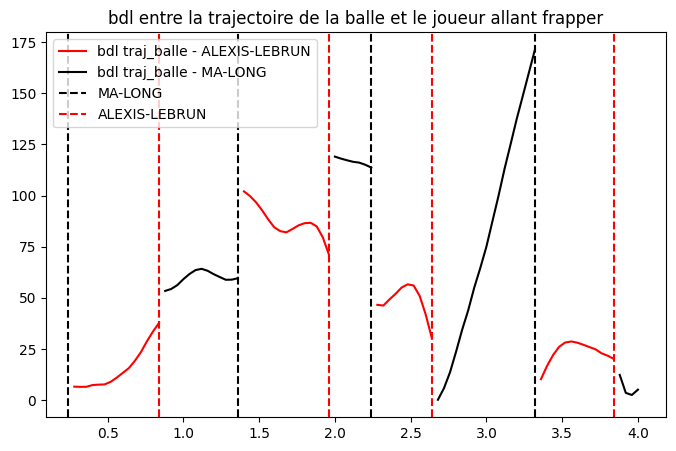

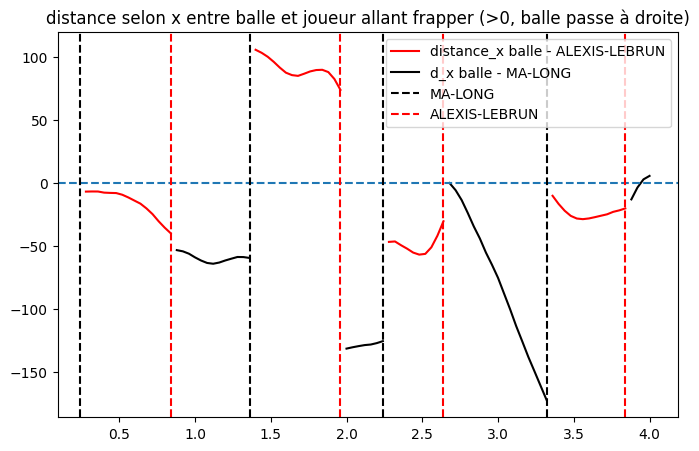

In [ ]:
bdl_jA, cote_balle_jA, bdl_jB, cote_balle_jB = bdl(compet, match, set, point)

plt.figure(figsize=(8, 5))
plt.plot(time_points, bdl_jA, color='red', label='bdl traj_balle - {}'.format(joueurA))
plt.plot(time_points, bdl_jB, color='black', label='bdl traj_balle - {}'.format(joueurB))

if frappe_service[0]==joueurA :
    plt.axvline(x=frappe_service[1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
elif frappe_service[0]==joueurB :
    plt.axvline(x=frappe_service[1]/25, color='k', linestyle='--', label='{}'.format(joueurB))

for i in range(len(time_frappe)):
    if time_frappe[i][0]==joueurA:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--')
    else:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--')
plt.title('bdl entre la trajectoire de la balle et le joueur allant frapper')
plt.legend()

plt.figure(figsize=(8, 5))
plt.plot(time_points, cote_balle_jA, color='red', label='distance_x balle - {}'.format(joueurA))
plt.plot(time_points, cote_balle_jB, color='black', label='d_x balle - {}'.format(joueurB))
plt.axhline(y=0, linestyle='--')

if frappe_service[0]==joueurA :
    plt.axvline(x=frappe_service[1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
elif frappe_service[0]==joueurB :
    plt.axvline(x=frappe_service[1]/25, color='k', linestyle='--', label='{}'.format(joueurB))

for i in range(len(time_frappe)):
    if time_frappe[i][0]==joueurA:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--', label='{}'.format(joueurA))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='r', linestyle='--')
    else:
        if i==0:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--', label='{}'.format(joueurB))
        else:
            plt.axvline(x=time_frappe[i][1]/25, color='k', linestyle='--')
plt.title('distance selon x entre balle et joueur allant frapper (>0, balle passe à droite)')
plt.legend()

Ajout de l'angle entre l'avant-bras et l'axe des ordonnées sur les images constitutives du gif

In [ ]:
angles_jA, angles_jB = angles_avant_bras(compet, match, set, point)

l=70 # longueur du trait
for i in range(len(pos_init_b)):
    image = Image.open('{}/output/match_{}/point_{}/image_{}.png'.format(chemin_tt_espace, match, point, i)).convert('RGB')
    draw=ImageDraw.Draw(image)

    ang=0
    if lateralite_jA=='gaucher' and angles_jA[0][i]!=None:
        ang=angles_jA[0][i]
    elif lateralite_jA=='droitier' and angles_jA[1][i]!=None:
        ang=angles_jA[1][i]
    if ang!=0:
        if 0<pos_init_jA[0][1]<h/2: # jA en haut
            y_y = int(pos_init_jA[i][1] + l)
            y_bras = int(pos_init_jA[i][1] + l*cos(ang))
        else:
            y_y = int(pos_init_jA[i][1] - l)
            y_bras = int(pos_init_jA[i][1] - l*cos(ang))
        draw.line([(int(pos_init_jA[i][0]), int(pos_init_jA[i][1])), (int(pos_init_jA[i][0]), y_y)], fill='grey', width=1) # ligne sur y
        draw.line([(int(pos_init_jA[i][0]), int(pos_init_jA[i][1])), (int(pos_init_jA[i][0] + l*sin(ang)), y_bras)], fill='black', width=1) # ligne sur avant-bras
        draw.text([int(pos_init_jA[i][0])+10, int(pos_init_jA[i][1])-30], '{}°'.format(int(ang*180/pi)), fill='black', font=ImageFont.truetype("arial.ttf", 20))
    
    ang=0
    if lateralite_jB=='gaucher' and angles_jB[0][i]!=None:
        ang=angles_jB[0][i]
    elif lateralite_jB=='droitier' and angles_jB[1][i]!=None:
        ang=angles_jB[1][i]
    if ang!=0:
        if 0<pos_init_jA[0][1]<h/2:
            y_y = int(pos_init_jB[i][1] - l)
            y_bras = int(pos_init_jB[i][1] - l*cos(ang))
        else:
            y_y = int(pos_init_jB[i][1] + l)
            y_bras = int(pos_init_jB[i][1] + l*cos(ang))
        draw.line([(int(pos_init_jB[i][0]), int(pos_init_jB[i][1])), (int(pos_init_jB[i][0]), y_y)], fill='grey', width=1)
        draw.line([(int(pos_init_jB[i][0]), int(pos_init_jB[i][1])), (int(pos_init_jB[i][0] + l*sin(ang)), y_bras)], fill='black', width=1)
        draw.text([int(pos_init_jB[i][0])+10, int(pos_init_jB[i][1])-30], '{}°'.format(int(ang*180/pi)), fill='black', font=ImageFont.truetype("arial.ttf", 20))

    image.save('{}/output/match_{}/point_{}/image_{}.png'.format(chemin_tt_espace, match, point, i))

Comparaison temps que prend la balle à atteindre un point sur sa trajectoire et le temps que prend le joueur à atteindre ce point.

In [ ]:
bdl_jA = bdl(compet, match, set, point)[0]

sit_deter_jA=[] # dans cette liste : les numéros de frame 3 frames après la frappe du jB. c'est à ces frames qu'on va essayer de déterminer si le jA peut ou non atteindre la balle.
for i in range(3, len(bdl_jA)):
    if bdl_jA[i-3]==None and bdl_jA[i-2]!=None :
        sit_deter_jA.append(i)
print(sit_deter_jA)

[9, 37, 59, 86]


In [ ]:
att_lat=atteintes_lateralite(compet, match)

nouv_att_lat=att_lat[0].copy()
for i in range(len(att_lat[0])-1,-1,-1): # att_lat[0] : jA ; [1] : jB
    d = sqrt(att_lat[0][i][0]**2 + att_lat[0][i][1]**2)
    if att_lat[0][i][1]<0 and att_lat[0][i][0]<50: # certains points sont visiblement faux (par ex derrière le joueur ou même position que son bassin) donc on les supprime
        del nouv_att_lat[i]
    if att_lat[0][i][2]=='revers' and d>135:
        del nouv_att_lat[i]
    if att_lat[0][i][2]=='coup_droit' and d>180:
        del nouv_att_lat[i]
    if att_lat[0][i][2]=='coup_droit' and d<80:
        del nouv_att_lat[i]

att_lat=[nouv_att_lat, att_lat[1]]

compteur_A_cd_jA = []
compteur_A_r_jA = []

for i in range(len(att_lat[0])):
    d = sqrt(att_lat[0][i][0]**2 + att_lat[0][i][1]**2)
    if att_lat[0][i][2]=='coup_droit':
        compteur_A_cd_jA.append(d)
    elif att_lat[0][i][2]=='revers':
        compteur_A_r_jA.append(d)

A_min_cd_jA, A_max_cd_jA, A_moy_cd_jA, A_med_cd_jA = min(compteur_A_cd_jA), max(compteur_A_cd_jA), sum(compteur_A_cd_jA)/len(compteur_A_cd_jA), statistics.median(compteur_A_cd_jA)
A_min_r_jA, A_max_r_jA, A_moy_r_jA, A_med_r_jA = min(compteur_A_r_jA), max(compteur_A_r_jA), sum(compteur_A_r_jA)/len(compteur_A_r_jA), statistics.median(compteur_A_r_jA)

print('Amplitudes minimale, maximale, moyenne et médiane en CD :', A_min_cd_jA, A_max_cd_jA, A_moy_cd_jA, A_med_cd_jA)
print('Amplitudes minimale, maximale, moyenne et médiane en revers :', A_min_r_jA, A_max_r_jA, A_moy_r_jA, A_med_r_jA)

Amplitudes minimale, maximale, moyenne et médiane en CD : 90.86735214255066 156.13198841100734 121.78705790962351 119.69662305509509
Amplitudes minimale, maximale, moyenne et médiane en revers : 61.78374978821212 127.01804712775345 98.25718146435969 100.72797317299016


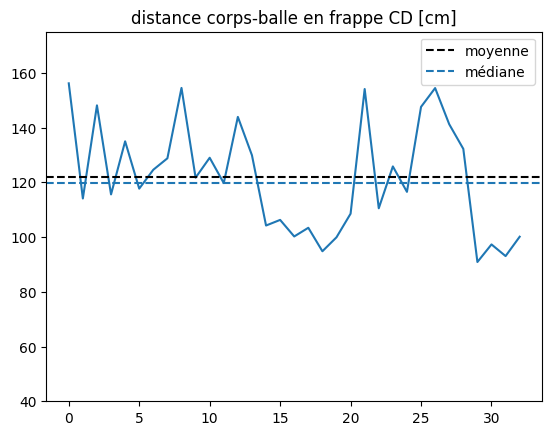

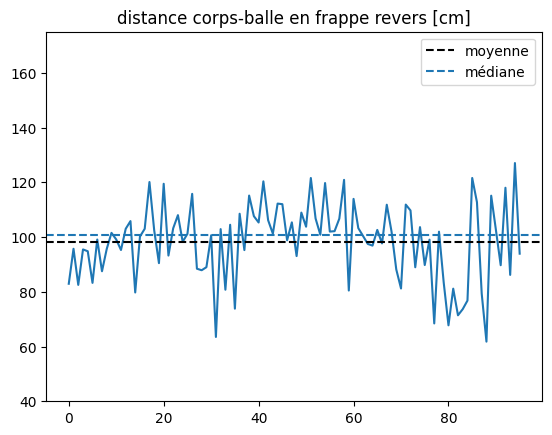

In [ ]:
plt.figure()
plt.plot(compteur_A_cd_jA)
plt.ylim([40,175])
plt.axhline(y=A_moy_cd_jA, linestyle='--', label='moyenne', color='black')
plt.axhline(y=A_med_cd_jA, linestyle='--', label='médiane')
plt.title('distance corps-balle en frappe CD [cm]')
plt.legend()

plt.figure()
plt.plot(compteur_A_r_jA)
plt.ylim([40,175])
plt.axhline(y=A_moy_r_jA, linestyle='--', label='moyenne', color='black')
plt.axhline(y=A_med_r_jA, linestyle='--', label='médiane')
plt.title('distance corps-balle en frappe revers [cm]')
plt.legend()

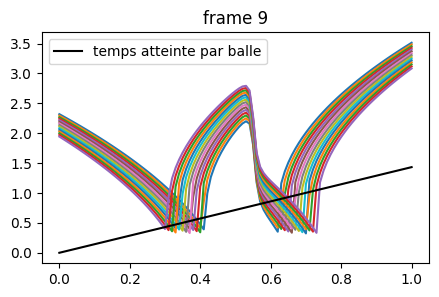

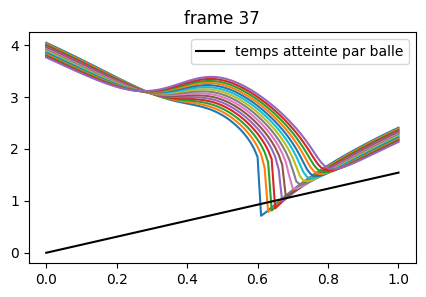

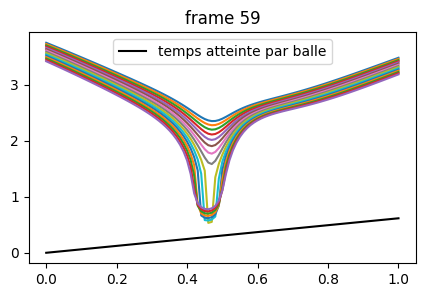

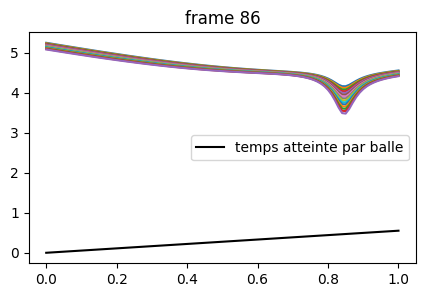

In [ ]:
# ajout trajectoire de la balle aux frames des situations déterminantes

if 0<pos_init_jA[0][1]<h/2:
    cote_jA='en haut'
else:
    cote_jA='en bas'

coord_pts_traj_balle=[] # dans chaque sous-liste : les coordonnées de plusieurs points (tous espacés de 'pas') sur la trajectoire de la balle. à partir de ces points on calcule time_to_point et temps que prend la balle à arriver (t=d/v)
d=np.linspace(0, 1, 101)
temps_atteinte_par_balle=[]
long_traj=600

for f in range(len(sit_deter_jA)): # cette boucle pour calculer coordonnées de points sur la trajectoire de la bamme + temps nécessaire à cette dernière pour y arriver
    x_b, y_b, vx_b, vy_b = pos_init_b[sit_deter_jA[f]][0], pos_init_b[sit_deter_jA[f]][1], vitesse_b[sit_deter_jA[f]][0], vitesse_b[sit_deter_jA[f]][1]
    if vx_b<0:
        xf_b = x_b - long_traj/sqrt(1 + vy_b**2/vx_b**2)
    else:
        xf_b = x_b + long_traj/sqrt(1 + vy_b**2/vx_b**2)
    if cote_jA=='en haut':
        yf_b = y_b - long_traj/sqrt(1 + vx_b**2/vy_b**2)
    elif cote_jA=='en bas':
        yf_b = y_b + long_traj/sqrt(1 + vx_b**2/vy_b**2)
    coord_pts_traj_balle.append([(xf_b-x_b)*d +x_b, (yf_b-y_b)*d + y_b])
    temps_atteinte_par_balle.append(d*long_traj/sqrt(vx_b**2 + vy_b**2)) # t = D/V avec V=norm(vecteur_vitesse) et D = d*400 (d appartient [0, 1] et on regarde les points sur la trajectoire de la balle, entre 0 et 4m de la balle (pas de discrétisation : 4cm))


longueurs_cd=np.linspace(A_min_cd_jA, A_max_cd_jA, 15)
longueurs_r=np.linspace(A_min_r_jA, A_max_r_jA, 15)


time_2_point_traj_balle=[[[] for _ in range(len(longueurs_cd))] for _ in range(len(sit_deter_jA))]
for f in range(len(sit_deter_jA)): # cette boucle pour calculer time to point entre position du joueur et point de telle sorte à ce que sa raquette soit sur traj balle.
    x_j, y_j, vx_j, vy_j = pos_init_jA[sit_deter_jA[f]][0], pos_init_jA[sit_deter_jA[f]][1], vitesse_jA[sit_deter_jA[f]][0], vitesse_jA[sit_deter_jA[f]][1]
    image = Image.open('{}/output/match_{}/point_{}/image_{}.png'.format(chemin_tt_espace, match, point, sit_deter_jA[f])).convert('RGB')
    draw=ImageDraw.Draw(image)
    for j in range(len(longueurs_cd)):
        long_bras=longueurs_r[j]
        for i in range(len(d)):
            x0 = coord_pts_traj_balle[f][0][i] # (x0, y0) : coor d'1 point sur la trajectoire de la balle
            y0 = coord_pts_traj_balle[f][1][i]
            if x0>x_j:
                x_att = x0 - long_bras/sqrt(1 + ((y0-y_j)/(x0-x_j))**2) # (x_att_, y_att) : coord du point à atteindre par le joueur de telle sorte à ce que sa raquette puisse atteindre le pt (x0, y0)
            else:
                x_att = x0 + long_bras/sqrt(1 + ((y0-y_j)/(x0-x_j))**2)
            if y0>y_j:
                y_att = y0 - long_bras/sqrt(1 + ((x0-x_j)/(y0-y_j))**2)
            else:
                y_att = y0 + long_bras/sqrt(1 + ((x0-x_j)/(y0-y_j))**2)
            time_2_point_traj_balle[f][j].append(time_to_point([x_j, y_j], [x_att, y_att], [vx_j, vy_j], F=60)) # rappel : time_to_point(depart, arrivee, vitesse_joueur)
            draw.ellipse((x0-2, y0-2, x0+2, y0+2), fill='purple')

    image.save('{}/output/match_{}/point_{}/sit_deter_{}.png'.format(chemin_tt_espace, match, point, sit_deter_jA[f]))


for f in range(len(sit_deter_jA)):
    plt.figure(figsize=(5, 3))
    for j in range(len(longueurs_cd)):
        plt.plot(d, time_2_point_traj_balle[f][j])
    plt.plot(d, temps_atteinte_par_balle[f], color='black', label='temps atteinte par balle')
    plt.title('frame {}'.format(sit_deter_jA[f]))
    plt.legend()

raffinement banane

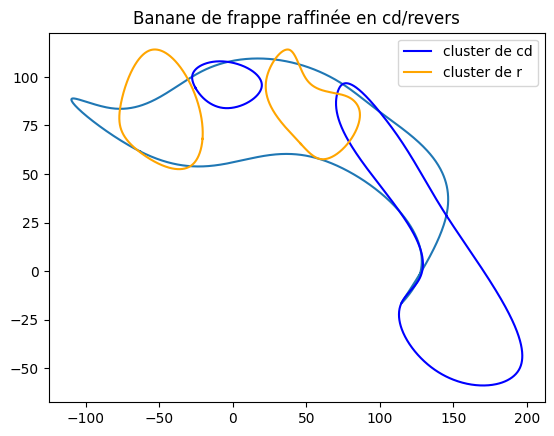

In [ ]:
coord_hull_cd, coord_hull_r = banane_alexis_cd_r()
coord_banane = np.array(banane_alexis())

plt.plot(coord_banane[:,0], coord_banane[:,1])
plt.plot(coord_hull_cd[0][0], coord_hull_cd[0][1], color='blue', label='cluster de cd')
plt.plot(coord_hull_cd[1][0], coord_hull_cd[1][1], color='blue')
plt.plot(coord_hull_r[0][0], coord_hull_r[0][1], color='orange', label='cluster de r')
plt.plot(coord_hull_r[1][0], coord_hull_r[1][1], color='orange')
plt.title('Banane de frappe raffinée en cd/revers')
plt.legend()
